In [1]:
# Python 3.6.8+
# author: Leonardo Filipe
# website: https://www.leonardofilipe.com
# contact: contact[at]leonardofilipe.com
# paper: https://arxiv.org/abs/0802.4411
# based on Zhang, L. implementation
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')

def Heston_Calls(series):
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho = series['rho'] # Correlation
    v0 = series['Cv0'] # Initial Variance (I use Call Implied Variance from BSM instead)
    T = series['T'] # Time to maturity
    s0 = series['s0'] # Spot Price
    K = series['K'] # Strike Price
    N = 10000 # Nº of simulations
    dt = 1/32 # Timestep granularity (related to the nº of steps being generated)
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    v=np.ones(N)*v0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v=v2
    payoff=np.maximum(S-K,0)
    return np.mean(payoff)

def Heston_Puts(series):
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho = series['rho'] # Correlation
    v0 = series['Pv0'] # Initial Variance (I use Put Implied Variance from BSM instead)
    T = series['T'] # Time to maturity
    s0 = series['s0'] # Spot Price
    K = series['K'] # Strike Price
    N = 10000 # Nº of simulations
    dt = 1/32 # Timestep granularity (related to the nº of steps being generated)
    vega=(4*kappa*theta/(sigma*sigma))
    K1=dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2=dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3=dt*(1-rho*rho)/2
    ss=K2+K3/2
    yita=4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh=ss*np.exp(-kappa*dt)/yita
    S=np.ones(N)*s0
    v=np.ones(N)*v0
    Ntime=int(T/dt)
    for i in range (0,Ntime):
        Zs=np.random.randn(1,N)
        lamb=v*yita
        W=np.random.noncentral_chisquare(vega,lamb)
        v2=W*np.exp(-kappa*dt)/yita
        K0=-lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S=S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v=v2
    payoff=np.maximum(K-S,0)
    return np.mean(payoff)

db = pd.read_hdf("optiondata.h5")
db['Now'] = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
HTest = pd.DataFrame({'T': db['Expiration'],'Cv0': db['CallImpVol']**2, 'Now': db['Now'],
                     's0': db['Spot'],'Pv0': db['PutImpVol']**2,'Put': db['PutMid'],
                     'K': db['Strike'],'Call': db['CallMid'],'Maturity': db['Maturity']})

HTest[HTest['Cv0'] < 0.001] = 0
HTest[HTest['Pv0'] < 0.001] = 0
HTest = HTest.loc[(HTest!=0).any(1)]
HTest = HTest.reset_index().drop('index',axis=1)

# Calibration can still be improved
HTest['Moneyness'] = abs(HTest['K']/HTest['s0'])
HTest['theta'] = 0.0722
HTest['kappa'] = 0.4816
HTest['sigma'] = 0.621
HTest['rho'] = -0.5527

In [3]:
HTest['Heston Call'] = round(HTest.apply(Heston_Calls, axis=1),2)
HTest['CError'] = abs(HTest['Heston Call']/HTest['Call']-1)
HTest['CError'].describe()

count    429.000000
mean       0.178927
std        0.162756
min        0.000000
25%        0.094402
50%        0.153734
75%        0.189287
max        0.949254
Name: CError, dtype: float64

In [4]:
HTest['Heston Put'] = round(HTest.apply(Heston_Puts, axis=1),2)
HTest['PError'] = abs(HTest['Heston Put']/HTest['Put']-1)
HTest['PError'].describe()

count    429.000000
mean       0.093282
std        0.040931
min        0.001145
25%        0.063533
50%        0.098258
75%        0.124688
max        0.189266
Name: PError, dtype: float64

In [5]:
HTest.groupby('Maturity')['CError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,0.445245,0.281460,0.003836,0.203742,0.476263,0.694224,0.811765
2018-06-15 17:30:00,62.0,0.159261,0.086543,0.000000,0.095412,0.166397,0.223864,0.334661
2018-09-21 17:30:00,105.0,0.159654,0.159082,0.001327,0.081442,0.132303,0.159872,0.949254
2018-12-21 17:30:00,125.0,0.137634,0.127555,0.000655,0.037280,0.136694,0.176573,0.698198
2019-03-15 17:30:00,98.0,0.158705,0.037796,0.039175,0.138633,0.172546,0.185942,0.216839


In [6]:
HTest.groupby('Maturity')['PError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,0.133487,0.035648,0.069121,0.108975,0.139542,0.158939,0.189266
2018-06-15 17:30:00,62.0,0.061381,0.017305,0.016611,0.051024,0.060721,0.069858,0.110761
2018-09-21 17:30:00,105.0,0.094647,0.033729,0.006676,0.078407,0.099602,0.119751,0.158514
2018-12-21 17:30:00,125.0,0.101414,0.040760,0.002123,0.084331,0.112059,0.128947,0.158255
2019-03-15 17:30:00,98.0,0.085627,0.043769,0.001145,0.045019,0.091747,0.120456,0.153364


<IPython.core.display.Javascript object>


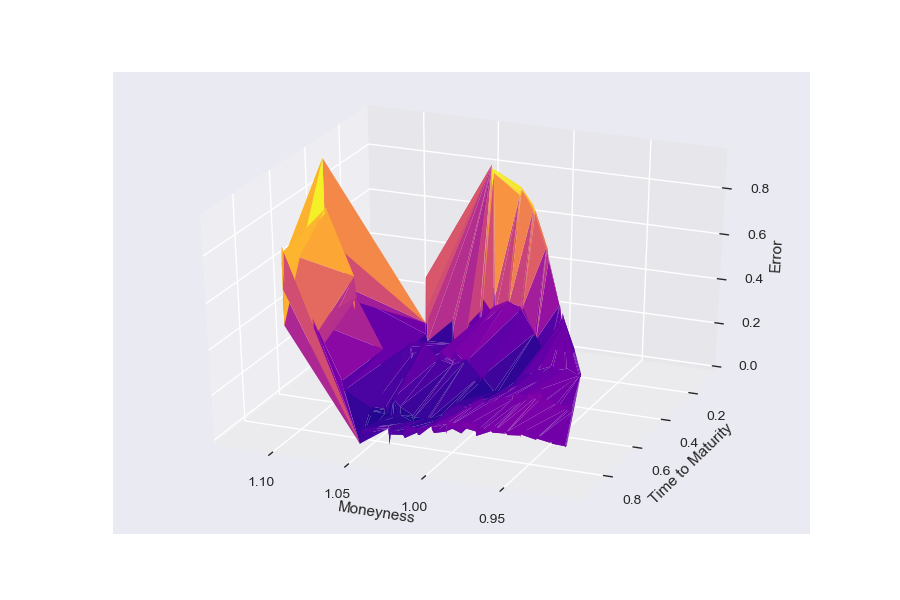

In [7]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['CError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()

<IPython.core.display.Javascript object>


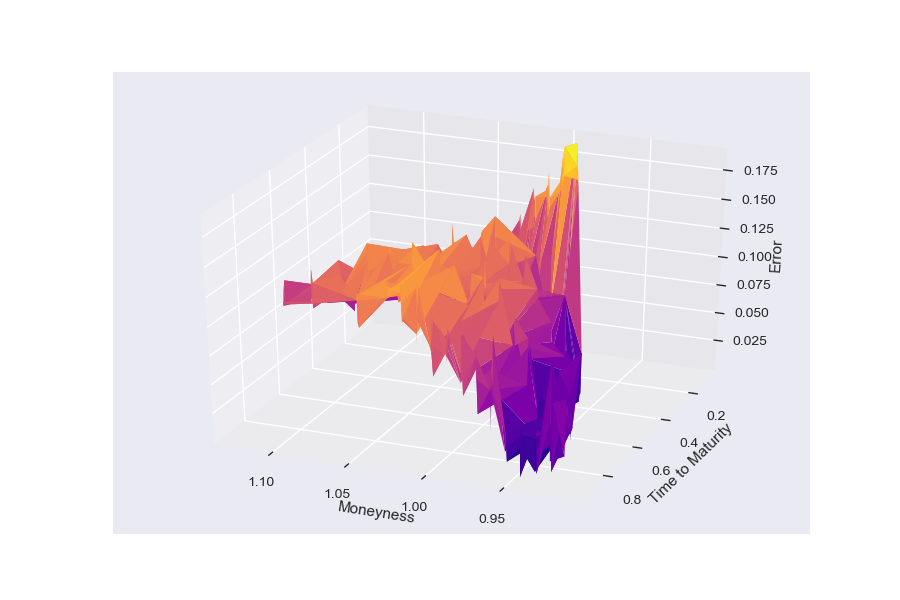

In [8]:
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['PError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()